In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import decomposition, ensemble
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from itertools import product
nltk.download('punkt')
np.random.seed(0)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcschneider/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install imblearn

In [3]:
#retrieving the url for FOMC Statement
html_page= requests.get('https://www.federalreserve.gov/newsevents/pressreleases/monetary20190320a.htm') 
soup= BeautifulSoup(html_page.content, 'html.parser')

In [4]:
#preview the soup... MMM soup
print(soup.prettify()[:1000])

<!DOCTYPE doctype html>
<html class="no-js" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1.0, minimum-scale=1.0 maximum-scale=1.6, user-scalable=1" name="viewport"/>
  <meta content=" Information received since the Federal Open Market Committee met in January indicates that the labor market remains strong but that growth of economic activity" name="description">
   <meta content="Federal Reserve issues FOMC statement" property="og:title">
    <meta content="Board of Governors of the Federal Reserve System" property="og:site_name">
     <meta content="article" property="og:type"/>
     <meta content=" Information received since the Federal Open Market Committee met in January indicates that the labor market remains strong but that growth of economic activity" property="og:description"/>
     <meta content="" property="og:image"/>
     <meta content="summary" name="twitter:card"/>


In [5]:
#search for the text in the article, isolate and save text
article = soup.find("div",attrs={"class":"col-xs-12 col-sm-8 col-md-8"}).getText()

In [6]:
# get json data from federal reserve 
r = requests.get('https://www.federalreserve.gov/json/ne-press.json')

In [7]:
# federal reserve json content
c = r.content

In [8]:
# clean up data using beautiful soup
json_file = BeautifulSoup(c)

In [9]:
json_file.text[0:3568]

'[{"d":"3/28/2019 4:30:00 PM","t":"Federal Reserve Board releases document providing additional information on its stress testing program","pt":"Banking and Consumer Regulatory Policy","l":"/newsevents/pressreleases/bcreg20190328a.htm"},{"d":"3/25/2019 2:00:00 PM","t":"Federal and state financial regulatory agencies issue interagency statement on supervisory practices regarding financial institutions affected by flooding in the Midwest","pt":"Banking and Consumer Regulatory Policy","l":"/newsevents/pressreleases/bcreg20190325a.htm"},{"d":"3/22/2019 5:00:00 PM","t":"Federal Reserve Board announces approval of proposals by First Interstate Bank","pt":"Orders on Banking Applications","l":"/newsevents/pressreleases/orders20190322a.htm"},{"d":"3/22/2019 12:00:00 PM","t":"Federal Reserve System publishes annual financial statements","pt":"Other Announcements","l":"/newsevents/pressreleases/other20190322a.htm"},{"d":"3/21/2019 12:00:00 PM","t":"Federal Reserve Board publishes report containin

In [10]:
# load data
json.loads(json_file.text[0:3568]+ ']')

[{'d': '3/28/2019 4:30:00 PM',
  't': 'Federal Reserve Board releases document providing additional information on its stress testing program',
  'pt': 'Banking and Consumer Regulatory Policy',
  'l': '/newsevents/pressreleases/bcreg20190328a.htm'},
 {'d': '3/25/2019 2:00:00 PM',
  't': 'Federal and state financial regulatory agencies issue interagency statement on supervisory practices regarding financial institutions affected by flooding in the Midwest',
  'pt': 'Banking and Consumer Regulatory Policy',
  'l': '/newsevents/pressreleases/bcreg20190325a.htm'},
 {'d': '3/22/2019 5:00:00 PM',
  't': 'Federal Reserve Board announces approval of proposals by First Interstate Bank',
  'pt': 'Orders on Banking Applications',
  'l': '/newsevents/pressreleases/orders20190322a.htm'},
 {'d': '3/22/2019 12:00:00 PM',
  't': 'Federal Reserve System publishes annual financial statements',
  'pt': 'Other Announcements',
  'l': '/newsevents/pressreleases/other20190322a.htm'},
 {'d': '3/21/2019 12:00:

># SAVED A COPY OF DATA AS JSON file for future use as of 03/28/2019
>with open("modFOMCdata.json", "w") as fp:
    json.dump(tosavejson, fp) 
    
>reference the json file if there are issues

In [11]:
# split the data on "Federal Reserve issues FOMC statement"
our_list = json_file.text.split("Federal Reserve issues FOMC statement")

In [12]:
links = []
for element in our_list[1:]:
    links.append('https://www.federalreserve.gov/newsevents' + element.split('newsevents')[1][0:36])

In [13]:
documents=[]
for link in links:
    html_page= requests.get(link) 
    soup= BeautifulSoup(html_page.content, 'html.parser')
    article = soup.find("div",attrs={"class":"col-xs-12 col-sm-8 col-md-8"}).getText()
    documents.append(article)

KeyboardInterrupt: 

In [ ]:
listoftags=[]
for doc in documents:
    listoftags.append([doc,'dovish'])

In [ ]:
df= pd.DataFrame(listoftags)

In [ ]:
df.to_excel("FOMC.xlsx")

In [ ]:
df=pd.read_excel("FOMC copy.xlsx")

In [1362]:
df.drop(columns = 'Unnamed: 2', inplace= True)

In [1363]:
df.columns = ["Documents", "Category"]

In [1364]:
def clean_data(data):
    cleaned_data = []
    for line in data:
        if not '[' in line and not ']' in line:
            for symbol in ",.?!''\n":
                line = line.replace(symbol, '').lower()
            cleaned_data.append(line)
    return "".join(cleaned_data)
data_without_brackets = clean_data(df.Documents[0])

In [1365]:
df['Documents']= df['Documents'].apply(lambda x: clean_data(x))

In [1366]:
from nltk.corpus import stopwords
import re

In [2384]:
stopwords_list = stopwords.words('english') + list(string.punctuation)

In [2886]:
#This function returns a PARAGRAPH of words that have stopwords and numbers removed
def process_data(Documents):
    tokens = nltk.word_tokenize(Documents)
    stopwords_removed = ' '.join([token.lower() for token in tokens if token not in stopwords_list])
    pattern= r"[a-z]+"
    regex_tokens = re.findall(pattern, stopwords_removed)
    return ' '.join(regex_tokens)

In [3099]:
document_words = df['Documents'].tolist()

In [2889]:
category = df['Category'].tolist()

In [2890]:
processed_data= list(map(process_data, document_words))

In [2892]:
#Process the data for each document and create a new column in the data frame with the preprocessed data
corpus= []
for i in processed_data:
    corpus.append(i)

In [2893]:
df['Processed_Data'] = np.nan

In [2894]:
df['Processed_Data'] = df.apply(lambda x: corpus)

In [3029]:
def tokenize(data):
    joined_data = ' '.join(data)
    tokenized_data = word_tokenize(data)
    
    return tokenized_data

tokenized_test_data = tokenize(df['Processed_Data'][0])

In [3030]:
df['Tokenized_Data']= df['Processed_Data'].apply(lambda x: tokenize(x))

## Word Tokenize and Frequency Distributions

In [3031]:
from nltk import word_tokenize, FreqDist

In [3032]:
fdist = FreqDist()
for row in df['Tokenized_Data']:
    for word in row:
        fdist[word] += 1

In [3033]:
count_vectorizer= CountVectorizer()

In [3034]:
processed_words_df = pd.DataFrame(df['Tokenized_Data'])
categories_df = pd.DataFrame(category)

In [3035]:
df_model= pd.concat([processed_words_df, categories_df], axis =1, sort= False)

In [3036]:
df_model.columns= ['Statement_Words', 'Category']

In [3037]:
def make_raw_doc(list_of_words):
    return ' '.join(list(list_of_words))

In [3038]:
df_model['raw_document'] = df_model.Statement_Words.apply(lambda x: make_raw_doc(x))

In [3039]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_model.raw_document, df_model.Category, train_size = .8, random_state = 0)

#do we need this


In [3040]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train ,y_train)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(X_train)
xtest_count =  count_vect.transform(X_test)


In [3041]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [3042]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=5000)
tfidf_vect_ngram.fit(X_train)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

## Count Vectorizing

In [3043]:
from sklearn.feature_extraction.text import CountVectorizer

In [3044]:
#create a vectorizer to ultimate create a sparse matrix of our corpus
vectorizer = CountVectorizer()

In [3045]:
#fits a model to our corpus
X = vectorizer.fit_transform(corpus)

## Endogeniety

In [3046]:
sorted_wordsbyappearance = sorted(vectorizer.vocabulary_.items(), key=lambda kv: kv[1], reverse=True)

In [3047]:
for i in sorted_wordsbyappearance:
    if i[1] > 800:
        stopwords_list.append(i[0])      

## Sparse Matrix and Sparsity 

In [3048]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurences: ', X.nnz)

Shape of Sparse Matrix:  (63, 617)
Amount of Non-Zero occurences:  8660


In [3049]:
sparsity = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('sparsity:', round(sparsity))

sparsity: 22


## Creating TD-IDF

In [3050]:
from sklearn.feature_extraction.text import TfidfTransformer

In [3051]:
tfidf_transformer = TfidfTransformer().fit(X)

In [3052]:
documents_tfidf = tfidf_transformer.transform(X)

In [3053]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(documents_tfidf, df_model.Category, train_size = .6, random_state= 0)


In [3054]:
X_resampled.shape[0]

106

## Handling Overfitting/Class Imbalance

In [3055]:
from imblearn.over_sampling import SMOTE, ADASYN

In [3056]:
print(df_model['Category'].value_counts()) #Previous original class distribution
X_resampled, y_resampled = SMOTE().fit_sample(documents_tfidf, df_model['Category']) 

dovish     53
hawkish    10
Name: Category, dtype: int64


## Multinomial Naive Bayes

In [3057]:
from sklearn.naive_bayes import MultinomialNB

In [3115]:
mb_model_resampled = MultinomialNB().fit(X_resampled, y_resampled)

In [3103]:
mb_all_predictions_resampled = mb_model_resampled.predict(X_resampled)
print(mb_all_predictions_resampled)

['hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 '

In [3104]:
print(classification_report(y_resampled, mb_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      0.68      0.81        53
     hawkish       0.76      1.00      0.86        53

   micro avg       0.84      0.84      0.84       106
   macro avg       0.88      0.84      0.84       106
weighted avg       0.88      0.84      0.84       106



In [3105]:
mb_model_resampled.score(X_resampled, y_resampled)

0.839622641509434

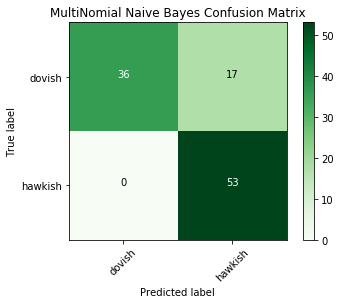

In [3106]:
cf1 = confusion_matrix(y_resampled, mb_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('MultiNomial Naive Bayes Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_resampled)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")

plt.colorbar();

## Random Forest

In [3063]:
from sklearn.ensemble import RandomForestClassifier

In [3064]:
rf_model_resampled = RandomForestClassifier().fit(X_resampled, y_resampled)

In [3065]:
rf_all_predictions_resampled = rf_model_resampled.predict(X_resampled)
print(rf_all_predictions_resampled)

['dovish' 'dovish' 'hawkish' 'dovish' 'hawkish' 'dovish' 'hawkish'
 'dovish' 'hawkish' 'dovish' 'hawkish' 'dovish' 'dovish' 'dovish'
 'hawkish' 'dovish' 'hawkish' 'hawkish' 'hawkish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'hawkish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish

In [3066]:
from sklearn.metrics import classification_report
print(classification_report(y_resampled, rf_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      1.00      1.00        53
     hawkish       1.00      1.00      1.00        53

   micro avg       1.00      1.00      1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



In [3067]:
rf_model_resampled.score(X_resampled, y_resampled)

1.0

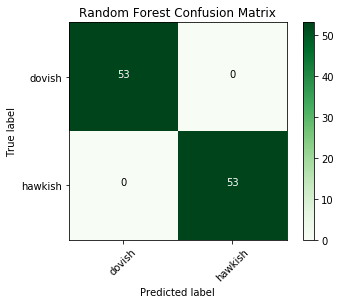

In [3068]:
cf1 = confusion_matrix(y_resampled, rf_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('Random Forest Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_resampled)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")

plt.colorbar();

## Logistic Regression 

In [3069]:
from sklearn.linear_model import LogisticRegression

In [3070]:
lr_model_resampled = LogisticRegression().fit(X_resampled,y_resampled)

In [3071]:
lr_all_predictions_resampled = lr_model_resampled.predict(X_resampled)
print(lr_all_predictions_resampled)

['hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish' 'hawkish'
 '

In [3072]:
from sklearn.metrics import classification_report
print(classification_report(y_resampled, lr_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      0.68      0.81        53
     hawkish       0.76      1.00      0.86        53

   micro avg       0.84      0.84      0.84       106
   macro avg       0.88      0.84      0.84       106
weighted avg       0.88      0.84      0.84       106



In [3073]:
lr_model_resampled.score(X_resampled, y_resampled)

0.839622641509434

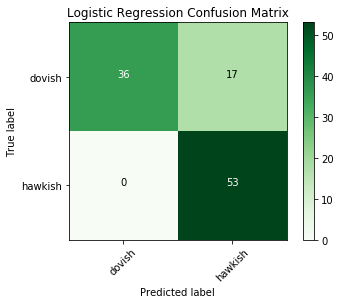

In [3074]:
cf1 = confusion_matrix(y_resampled, lr_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_resampled)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")

plt.colorbar();

In [3075]:
# change test train split to test 
# play with stop words amount

## Making Predictions

In [3076]:
X_test[0]

<1x617 sparse matrix of type '<class 'numpy.float64'>'
	with 165 stored elements in Compressed Sparse Row format>

In [3077]:
X_resampled.shape[0]

106

In [3078]:
y_resampled

array(['dovish', 'dovish', 'hawkish', 'dovish', 'hawkish', 'dovish',
       'hawkish', 'dovish', 'hawkish', 'dovish', 'hawkish', 'dovish',
       'dovish', 'dovish', 'hawkish', 'dovish', 'hawkish', 'hawkish',
       'hawkish', 'dovish', 'dovish', 'dovish', 'dovish', 'dovish',
       'dovish', 'dovish', 'dovish', 'dovish', 'dovish', 'dovish',
       'dovish', 'dovish', 'dovish', 'dovish', 'dovish', 'dovish',
       'dovish', 'dovish', 'dovish', 'dovish', 'dovish', 'dovish',
       'dovish', 'dovish', 'dovish', 'dovish', 'dovish', 'dovish',
       'dovish', 'dovish', 'dovish', 'dovish', 'dovish', 'dovish',
       'dovish', 'dovish', 'dovish', 'hawkish', 'dovish', 'dovish',
       'dovish', 'dovish', 'dovish', 'hawkish', 'hawkish', 'hawkish',
       'hawkish', 'hawkish', 'hawkish', 'hawkish', 'hawkish', 'hawkish',
       'hawkish', 'hawkish', 'hawkish', 'hawkish', 'hawkish', 'hawkish',
       'hawkish', 'hawkish', 'hawkish', 'hawkish', 'hawkish', 'hawkish',
       'hawkish', 'hawkish', 'h

In [3079]:
for i in range(106):
    print(rf_model_resampled.predict(X_resampled[i])[0])

dovish
dovish
hawkish
dovish
hawkish
dovish
hawkish
dovish
hawkish
dovish
hawkish
dovish
dovish
dovish
hawkish
dovish
hawkish
hawkish
hawkish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
dovish
hawkish
dovish
dovish
dovish
dovish
dovish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish
hawkish


In [3080]:
rf_model_resampled.predict(X_resampled[4])[0]

'hawkish'

In [3081]:
help(rf_model_resampled)

Help on RandomForestClassifier in module sklearn.ensemble.forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators='warn', criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimator

In [3082]:
rf_model_resampled.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00835297,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00614665, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0033208 , 0.        ,
       0.        , 0.00191129, 0.        , 0.        , 0.        ,
       0.        , 0.00147442, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00408618, 0.        , 0.     

In [3083]:
rf_model_resampled.predict(X_resampled[15])

array(['dovish'], dtype=object)

In [3084]:
hawkish = df_model.loc[df_model['Category']=='hawkish', 'raw_document']

In [3085]:
df_hawkish = pd.DataFrame(hawkish)

In [3086]:
for hawk in hawkish:
    print(hawk)

information federal open market committee met november indicates labor market continued economic activity job gains average months low household continued grow growth business fixed investment moderated pace earlier month basis overall inflation inflation items food energy near indicators longer term inflation expectations little changed balanceconsistent mandate committee foster maximum employment committee judges gradual increases federal funds consistent expansion economic activity labor market conditions inflation near committees objective medium committee judges economic outlook balanced continue monitor global economic financial developments assess implications economic outlookin expected labor market conditions inflation committee decided federal funds determining future adjustments federal funds committee assess expected economic conditions maximum employment objective inflation objective assessment account information including measures labor market conditions indicators infla

In [3111]:
def mb_predictions(document):
    X = vectorizer.transform([document])
    documents_tfidf = tfidf_transformer.transform(X)
    return mb_model_resampled.predict(documents_tfidf)[0]

In [3120]:
got_quotes = 'Never forget what you are, for surely the world will not. Make it your strength. Then it can never be your weakness. Armour yourself in it, and it will never be used to hurt you.'

In [3116]:
mb_predictions('ee met november indicates labor market continued strengthen economic activity rising strong rate job gains strong average recent months unemployment rate remained low household spending continued grow strongly growth business fixed investment moderated rapid pace earlier year month basis overall inflation inflation items food energy remain near percent indicators longer term inflation expectations little changed balanceconsistent statutory mandate committee seeks foster maximum employment price stability committee judges gradual increases target range federal funds rate consistent sustained expansion economic activity strong labor market conditions inflation near committees symmetric percent objective medium term committee judges risks economic outlook roughly balanced continue monitor global economic financial developments assess implications economic outlookin view realized expected labor market conditions inflation committee decided raise target range federal funds rate percentin determining timing size future adjustments target range federal funds rate committee assess realized expected economic conditions relative maximum employment objective symmetric percent inflation objective assessment take account wide range information including measures labor market conditions indicators inflation pressures inflation expectations readings financial international developmentsvoting fomc monetary policy action jerome h powell chairman john c williams vice chairman thomas barkin raphael w bostic michelle w bowman lael brainard richard h clarida mary c daly loretta j mester randal k quarlesimplementation note issued december')


mb_predictions('Never forget what you are, for surely the world will not. Make it your strength. Then it can never be your weakness. Armour yourself in it, and it will never be used to hurt you.')

'dovish'

In [3113]:
mb_predictions('In view of realized and expected labor market conditions and inflation, the Committee decided to maintain the target range for the federal funds rate at 2 to 2-1/4 percent.')

'hawkish'

In [3114]:
mb_predictions('The Federal Open Market Committee decided today to raise its target for the federal funds rate by 25 basis points to 4-1/2 percent.')

'hawkish'

In [3091]:
def rf_predictions(document):
    X = vectorizer.transform([document])
    documents_tfidf = tfidf_transformer.transform(X)
    return rf_model_resampled.predict(documents_tfidf)[0]

In [3092]:
rf_predictions('information received since federal open market committee met november indicates labor market continued strengthen economic activity rising strong rate job gains strong average recent months unemployment rate remained low household spending continued grow strongly growth business fixed investment moderated rapid pace earlier year month basis overall inflation inflation items food energy remain near percent indicators longer term inflation expectations little changed balanceconsistent statutory mandate committee seeks foster maximum employment price stability committee judges gradual increases target range federal funds rate consistent sustained expansion economic activity strong labor market conditions inflation near committees symmetric percent objective medium term committee judges risks economic outlook roughly balanced continue monitor global economic financial developments assess implications economic outlookin view realized expected labor market conditions inflation committee decided raise target range federal funds rate percentin determining timing size future adjustments target range federal funds rate committee assess realized expected economic conditions relative maximum employment objective symmetric percent inflation objective assessment take account wide range information including measures labor market conditions indicators inflation pressures inflation expectations readings financial international developmentsvoting fomc monetary policy action jerome h powell chairman john c williams vice chairman thomas barkin raphael w bostic michelle w bowman lael brainard richard h clarida mary c daly loretta j mester randal k quarlesimplementation note issued december')

'hawkish'

In [3117]:
rf_predictions('Never forget what you are, for surely the world will not. Make it your strength. Then it can never be your weakness. Armour yourself in it, and it will never be used to hurt you.')

'dovish'

In [3093]:
rf_predictions('In view of realized and expected labor market conditions and inflation, the Committee decided to maintain the target range for the federal funds rate at 2 to 2-1/4 percent.')

'dovish'

In [3094]:
rf_predictions('The Federal Open Market Committee decided today to raise its target for the federal funds rate by 25 basis points to 4-1/2 percent.')

'dovish'

In [3095]:
def lr_predictions(document):
    X = vectorizer.transform([document])
    documents_tfidf = tfidf_transformer.transform(X)
    return lr_model_resampled.predict(documents_tfidf)[0]

In [3096]:
lr_predictions('information received since federal open market committee met november indicates labor market continued strengthen economic activity rising strong rate job gains strong average recent months unemployment rate remained low household spending continued grow strongly growth business fixed investment moderated rapid pace earlier year month basis overall inflation inflation items food energy remain near percent indicators longer term inflation expectations little changed balanceconsistent statutory mandate committee seeks foster maximum employment price stability committee judges gradual increases target range federal funds rate consistent sustained expansion economic activity strong labor market conditions inflation near committees symmetric percent objective medium term committee judges risks economic outlook roughly balanced continue monitor global economic financial developments assess implications economic outlookin view realized expected labor market conditions inflation committee decided raise target range federal funds rate percentin determining timing size future adjustments target range federal funds rate committee assess realized expected economic conditions relative maximum employment objective symmetric percent inflation objective assessment take account wide range information including measures labor market conditions indicators inflation pressures inflation expectations readings financial international developmentsvoting fomc monetary policy action jerome h powell chairman john c williams vice chairman thomas barkin raphael w bostic michelle w bowman lael brainard richard h clarida mary c daly loretta j mester randal k quarlesimplementation note issued december')

'hawkish'

In [3097]:
lr_predictions('In view of realized and expected labor market conditions and inflation, the Committee decided to maintain the target range for the federal funds rate at 2 to 2-1/4 percent.')

'dovish'

In [3098]:
lr_predictions('The Federal Open Market Committee decided today to raise its target for the federal funds rate by 25 basis points to 4-1/2 percent.')

'dovish'

In [3119]:
lr_predictions('Never forget what you are, for surely the world will not. Make it your strength. Then it can never be your weakness. Armour yourself in it, and it will never be used to hurt you.')

'dovish'